### Notebook for the QC analysis of anndata object with Fawkner-Corbett_2021 Visium data 

- **Developed by:** Anna Maguza
- **Affilation:** Wuerzburg Institute for System Immunology
- **Date:** 27th January 2024
- **Last modified date:** 5th August 2024

#### Import packages

In [1]:
import pandas as pd
import anndata
import os
import scanpy as sc
import numpy as np

from scipy.sparse import issparse


#### Set up cells

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                         10.0.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.0
backcall                    0.2.0
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.0
colorama                    0.4.6
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
executing                   2.0.0
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
idna                        3.4
igraph                      0.11.2
ipykernel                   6.25.2
ipywidgets                  8.1.1
isoduration                 NA
jedi   

#### Load anndata object

In [3]:
data_dir = 'raw_data/Fawkner-Corbett_2021/Visium_data/'
adata = anndata.read_h5ad(f'{data_dir}/Fawkner_Corbett_2021_raw_all_samples_unprocesses.h5ad')

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


+ Make barcodes unique

In [4]:
adata.obs.index.is_unique

False

In [5]:
adata.obs['barcode'] = adata.obs.index.copy()

adata.obs['barcode_sample_ID'] = adata.obs['barcode'].astype(str) + '_' + adata.obs['Sample_ID'].astype(str)

adata.obs.index = adata.obs['barcode_sample_ID']

In [6]:
adata.obs.index.is_unique

False

In [ ]:
adata = adata[~adata.obs.index.duplicated(keep='first')].copy()

In [10]:
adata.obs.index.is_unique

True

In [11]:
adata.var_names_make_unique()

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


* Basic filtering

In [12]:
sc.pp.filter_cells(adata, min_genes = 200)

filtered out 9 cells that have less than 200 genes expressed


/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


#### Perform basic QC

In [13]:
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top= None, log1p = False)

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith('RPS','RPL')  # annotate the group of rybosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

+ Visualise QC covariates

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/amaguza/miniforge3/envs/scanpy_env/lib/python

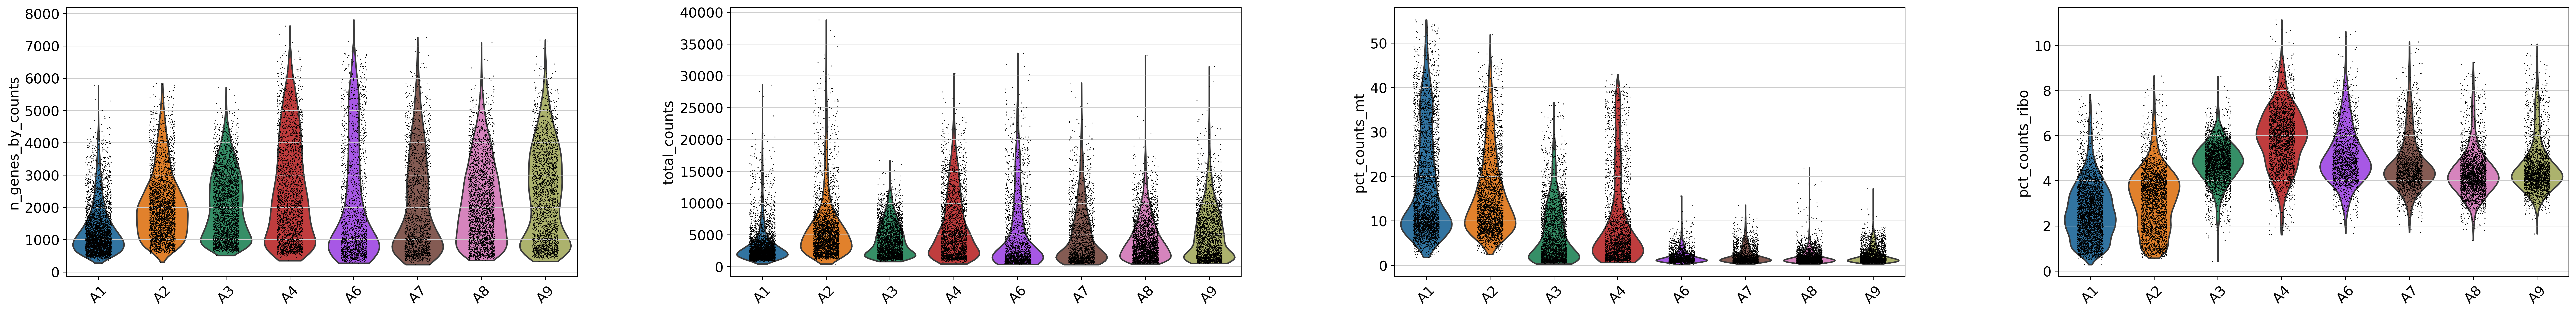

In [15]:
sc.set_figure_params(dpi=180, figsize=(8, 5))
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'Sample_ID', rotation = 45)

In [16]:
adata.write(f'{data_dir}/Fawkner_Corbett_2021_raw_all_samples_with_QC.h5ad')
